## Import Packages

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import Input
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import geopandas as gp
import matplotlib as mlt
from matplotlib import colors as c

## Import Required Data

In [2]:
#time_series_data = genfromtxt('time_series_data_pm2p5.csv', delimiter=',', skip_header = 1)
time_series_data = genfromtxt('GRIN_Imputed_Pune_Data.csv', delimiter=',', skip_header = 1) # Load GRIN Imputed Data
Aqm_Pune = pd.read_csv('pune-aqm.csv')
Sensor_Location = pd.read_csv('pune_sensor.csv')
map_ms=gp.read_file('maharashtra_administrative/maharashtra_administrative.shp',encoding="utf-8")
map_pune = map_ms[map_ms['NAME'] == 'Pune']

### Data Selection

In [3]:
time_series_data = time_series_data[2:,1:].T               # Discard Unwanted rows and Columns from the Data
time_series_data

array([[ 4.25    ,  4.25    ,  4.25    , ..., 13.      , 14.      ,
        14.5     ],
       [22.716587, 22.716587, 22.716587, ...,  9.408189,  9.408189,
         9.408189],
       [ 6.727941,  6.727941,  6.727941, ...,  3.      ,  2.      ,
         3.      ],
       ...,
       [18.684256, 18.684256, 18.684256, ...,  4.375   ,  4.375   ,
         0.      ],
       [22.382853, 22.382853, 22.382853, ...,  3.      ,  4.      ,
         3.      ],
       [13.      , 13.      , 13.      , ...,  9.      ,  9.      ,
         9.      ]])

### Order Latitude and Longitude according to the Data

In [4]:
dum = Aqm_Pune.id.unique()    # Get all the sensor ID's
known_latlon = pd.DataFrame(columns = ['latitude', 'longitude'])       # Create an empty DataFrame to store 'known' latitude and longitude

for i in range(len(Sensor_Location)):           # Loop over all the sensor loations in the data
    single_sensor_location = Sensor_Location[Sensor_Location['id'] == dum[i]].reset_index(drop=True,inplace=False)   # Get information of a single sensor
    known_latlon.loc[len(known_latlon.index)] = [(single_sensor_location['latitude'].values)[0], (single_sensor_location['longitude'].values)[0]]    # Append dummy data frame to the ordered data frame 
#known_latlon

#### Create a grid of Latitude and Longitudes around existing sensor locations

In [5]:
lat_min = min(known_latlon['latitude']) # Minimum latitude value
lat_max = max(known_latlon['latitude']) # Maximum latitude value
lng_min = min(known_latlon['longitude']) # Minimum longitude value
lng_max = max(known_latlon['longitude']) # Maximum longitude value
ext = 0.01 # Value of extension to the grid
grid_length = 10
xx = np.linspace(lng_min-ext, lng_max+ext, grid_length) # Get 100 longitude values between maximum and minimum longitude values
yy = np.linspace(lat_min-ext, lat_max+ext, grid_length) # Get 100 latitude values between maximum and minimum latitudes values

unknown_set = np.meshgrid(xx, yy) # Get grid with arrays xx and yy
gridx = np.reshape(unknown_set[0], (1, grid_length*grid_length)) # Array of all longitude values in the grid
gridy = np.reshape(unknown_set[1], (1, grid_length*grid_length)) # Array of all latitude values in the grid

gridyx = np.concatenate((gridy.T, gridx.T), axis=1) # Concatenate latitude and longitude arrays

unknown_latlon = pd.DataFrame(columns = ['latitude', 'longitude']) # Define an empty DataFrame for unknown latitude and longitude values
unknown_latlon[['latitude', 'longitude']] = gridyx # Assign Concatenated latitude and longitude array to unknown latitude longitude DataFrame

latlon = pd.concat([known_latlon, unknown_latlon], ignore_index = True) # Concatenate both known and Unknown lat lon DataFrame with new index
#latlon

### Initialize variables to get Date-Time object for Sensor Measurements for every 15 min interval

In [6]:
from datetime import datetime, timedelta, timezone
start_date = '2020-10-16 05:30:00'     # Starting date-time for data
#date_format_str = '%Y-%m-%d %H:%M:%S%z'
date_format_str = '%Y-%m-%d %H:%M:%S'  # Date-time format
end_date = '2022-07-21 05:30:00'       # Ending date-time for data
d0 = datetime.strptime(start_date, date_format_str) # Converting starting date-time string to datetime Object
d1 = datetime.strptime(end_date, date_format_str)   # Converting ending date-time string to datetime Object
diff = d1-d0      # Get difference between stating date-time object to ending date-time object
sampling_frequency = 0.25       # Sampling frequency (0.25 = 15min, 0.5 = 30min, 1 = 1hr)
end_slot = start_date           # Initiate ending time slot as the starting time
start_slot = datetime.strptime(start_date, date_format_str) # Initiate starting time slot as the starting time
                                                            # Initially start and end slots are the same (before iteration)

### Get Date-Time object for Sensor Measurements for every 15 min interval

In [7]:
DateTime = start_slot  # Variable to store date-time object data, Initiate DateTime with starting date-time object and store 
for j in range(int(diff.days*24*(1/sampling_frequency))):      # Loop to get date-time objects for sensor data
    end_slot = start_slot+timedelta(hours = sampling_frequency) # Change end_slot for the loop by adding 15 mins to start_slot
    start_slot = end_slot    # Change start_slot for the next loop by assiging end_slot to start_slot
    DateTime = np.append(DateTime, start_slot)  # Append new start_slot (next date-time object) to DateTime variable

### Data Selection and Data Scaling 

In [8]:
actual_data = time_series_data#[:-1,1:1001]          # Select the data range [0,T] for reference
spatio_temporal_observations_data = time_series_data#[:-1,1:1001]   # Select the data range [0,T] for manipulation
data_scaler = StandardScaler()           # Define StandardScaler instantiation for data scaling
data_scaler.fit(spatio_temporal_observations_data)    # Fit Spatio-Temporal data using fit() method of StandardScaler
spatio_temporal_observations = data_scaler.transform(spatio_temporal_observations_data)  # Transform the Spatio-Temporal data using transform() method of StandardScaler

### Principle Component Analysis

In [9]:
K = min(spatio_temporal_observations.shape[1], spatio_temporal_observations.shape[0]-1)   # Number of Components
pca = PCA(n_components=K)       # PCA with K components
pca.fit(spatio_temporal_observations)      # Fit PCA to Spatio-Temporal data

PCA(n_components=49)

### Explained Variance from PCA analysis

In [10]:
exp_var = 0.95
explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance[explained_variance >= exp_var]
xmin = np.where(explained_variance >= exp_var)[0]

### Plot Explained variance 

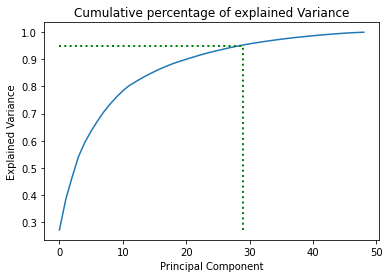

In [11]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.vlines(x=xmin[0], ymin=explained_variance[0], ymax=exp_var, colors='green', ls=':', lw=2, label='vline_single - partial height')
plt.hlines(y=exp_var, xmin=0, xmax=xmin[0], color='green', ls=':', lw=2)
plt.title('Cumulative percentage of explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

### Computer Spatial Coefficients and Process them through standard scaler

In [12]:
K_ = xmin[0]
#K_ = 48
alpha_k_ = np.dot(pca.components_[:K_], spatio_temporal_observations.T)  # Spatial Coefficients = dot product of first K PCA components and Spatiotemporal Observations
#alpha_k_ = np.concatenate((alpha_k_, np.zeros([alpha_k_.shape[0], len(unknown_latlon)])), axis=1)
coff_scaler = StandardScaler()                # Apply Standard Scaler to the Coefficients
coff_scaler.fit(alpha_k_.T)                     # Fit spatial coefficients to standard scaler
alpha_k = coff_scaler.transform(alpha_k_.T)     # Transform Spatial Coefficients through standard scaler
alpha_k.shape

(50, 29)

### Visualized coefficients

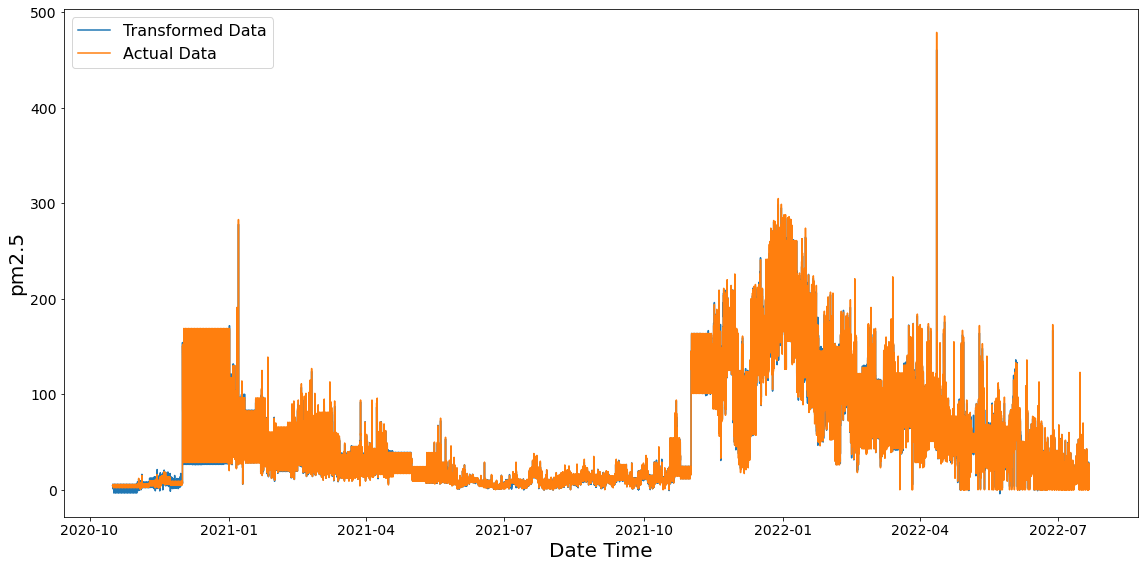

In [13]:
y_ini_prediction = np.dot(coff_scaler.inverse_transform(alpha_k), pca.components_[:K_])   # Represent data using spatial coefficients and orthogonal basis
y_ini_pred_trans = data_scaler.inverse_transform(y_ini_prediction)     # Tranform the represented data using data scaler
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(DateTime[:-1], y_ini_pred_trans[0], label = 'Transformed Data')     # Plot transformed data
ax.plot(DateTime[:-1], actual_data[0], label = 'Actual Data')          # Plot Actual Data
ax.set_ylabel('pm2.5',fontsize=20)
ax.set_xlabel('Date Time',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(loc='best', fontsize=16)
plt.tight_layout()
#plt.savefig('fig/ignnk_pm2p5.pdf')
plt.show()

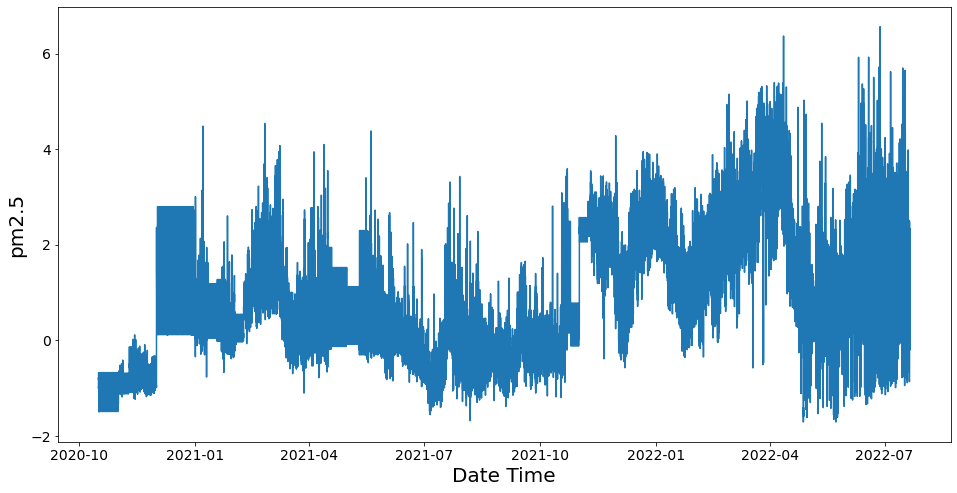

In [14]:
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(DateTime[:-1], y_ini_prediction[0])
ax.set_ylabel('pm2.5',fontsize=20)
ax.set_xlabel('Date Time',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

### Model Training
Perform model training on Spatial Coefficients\
A sequential model with one input, one output and 6 Dense hidden layers\
Initializer                --> HeNormal()\
Loss Function              --> Mean Squared Error\
Activation Function        --> relu\
Normalization              --> Batch Normalization\
Number of Hidden Layers    --> 6\
Optimizer                  --> Nadam\
                               Learning Rate - 0.0001\
                               Metrics - Accuracy

In [15]:
initializer = initializers.HeNormal()    # Initializer
es = EarlyStopping(monitor='loss', mode='min', verbose=0) # Early Stopping criterion
loss_fn = losses.MeanSquaredError()      # Loss function
act_fn = 'relu'                          # Activation function

# Sequential Model with one input, one output and 6 Dense hidden layers
model = Sequential() # Model
#model.add(Dense(100, input_shape=(1,), activation="sigmoid"))
model.add(Input(shape=(2,), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(BatchNormalization())
model.add(Dense(512, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer-1')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(256, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer-2')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(128, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer-3')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(64, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer_4')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(32, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer-5')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(16, activation= act_fn, kernel_initializer=initializer, name='Hidden-Layer-6')) # Hidden Layer, softplus(x) = log(exp(x) + 1)
model.add(BatchNormalization())
model.add(Dense(K_, activation= act_fn, name='Output-Layer')) # Output Layer, sigmoid(x) = 1 / (1 + exp(-x))

# Compile model 
model.compile(#optimizer = SGD(learning_rate=0.01, momentum=0.9),
              optimizer = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"),
              #optimizer='Nadam', # default='rmsprop', an algorithm to be used in backpropagation
              loss=loss_fn, # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              #metrics=tf.keras.metrics.Metri,#, 'Precision', 'Recall'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              metrics=['Accuracy']#, 'Precision', 'Recall'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              #loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              #weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              #run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              #steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

# Fit training data
model.fit(known_latlon.to_numpy(), # input data
          alpha_k, # target data
          batch_size=4, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
          epochs=500, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          #verbose='auto', # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
          #callbacks=[es], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
          #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
          #validation_data=(known_latlon.to_numpy(), alpha_k.T), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
          #shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
          #class_weight={0 : 0.3, 1 : 0.7}, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
          #sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
          #initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
          #steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
          #validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
          #validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
          #validation_freq=3, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
          #max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
          #workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
          #use_multiprocessing=False, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
         )

2022-09-26 21:03:09.682856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
13/13 [==============================] - 2s 4ms/step - loss: 1.3819 - Accuracy: 0.0000e+00
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3774 - Accuracy: 0.0000e+00
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 1.3568 - Accuracy: 0.0200
Epoch 4/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3239 - Accuracy: 0.0400
Epoch 5/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3160 - Accuracy: 0.0200
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3171 - Accuracy: 0.0200
Epoch 7/500
13/13 [==============================] - 0s 4ms/step - loss: 1.3243 - Accuracy: 0.0800
Epoch 8/500
13/13 [==============================] - 0s 4ms/step - loss: 1.2831 - Accuracy: 0.0400
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 1.2996 - Accuracy: 0.0200
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 1.2314 - Accuracy: 0.0600
E

13/13 [==============================] - 0s 3ms/step - loss: 1.0553 - Accuracy: 0.0200
Epoch 164/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0515 - Accuracy: 0.0200
Epoch 165/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0213 - Accuracy: 0.0200
Epoch 166/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0216 - Accuracy: 0.0200
Epoch 167/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0154 - Accuracy: 0.0800
Epoch 168/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0270 - Accuracy: 0.0800
Epoch 169/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0265 - Accuracy: 0.0800
Epoch 170/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0140 - Accuracy: 0.0200
Epoch 171/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0338 - Accuracy: 0.0800
Epoch 172/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0150 - Accuracy: 0.0400
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 1.0085 - Accuracy: 0.0800
Epoch 245/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9991 - Accuracy: 0.0200
Epoch 246/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9965 - Accuracy: 0.0400
Epoch 247/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0141 - Accuracy: 0.0200
Epoch 248/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0227 - Accuracy: 0.0000e+00
Epoch 249/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0029 - Accuracy: 0.0400
Epoch 250/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0183 - Accuracy: 0.0200
Epoch 251/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0106 - Accuracy: 0.1200
Epoch 252/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0048 - Accuracy: 0.0400
Epoch 253/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0082 - Accuracy: 0.0200


13/13 [==============================] - 0s 4ms/step - loss: 1.0017 - Accuracy: 0.1000
Epoch 326/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9891 - Accuracy: 0.1000
Epoch 327/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0094 - Accuracy: 0.0600
Epoch 328/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9926 - Accuracy: 0.0200
Epoch 329/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9932 - Accuracy: 0.0600
Epoch 330/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9863 - Accuracy: 0.0800
Epoch 331/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0039 - Accuracy: 0.1000
Epoch 332/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0043 - Accuracy: 0.0400
Epoch 333/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9905 - Accuracy: 0.0600
Epoch 334/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9946 - Accuracy: 0.0200
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.9936 - Accuracy: 0.0800
Epoch 407/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0019 - Accuracy: 0.0600
Epoch 408/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9989 - Accuracy: 0.1200
Epoch 409/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9899 - Accuracy: 0.0200
Epoch 410/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9940 - Accuracy: 0.0600
Epoch 411/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9985 - Accuracy: 0.0200
Epoch 412/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9989 - Accuracy: 0.0200
Epoch 413/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0045 - Accuracy: 0.0400
Epoch 414/500
13/13 [==============================] - 0s 4ms/step - loss: 0.9923 - Accuracy: 0.0600
Epoch 415/500
13/13 [==============================] - 0s 4ms/step - loss: 1.0107 - Accuracy: 0.1200
Epoc

### Prediction Step

In [16]:
pred_intr_op = model.predict(unknown_latlon.to_numpy(), batch_size = 128)       # Perform Interpolation at unknown locations
pred_train_op = model.predict(known_latlon.to_numpy(), batch_size = 128)     # Perform Prediction on Training data

### Compare and Plot Actual and Predicted Test Coefficients

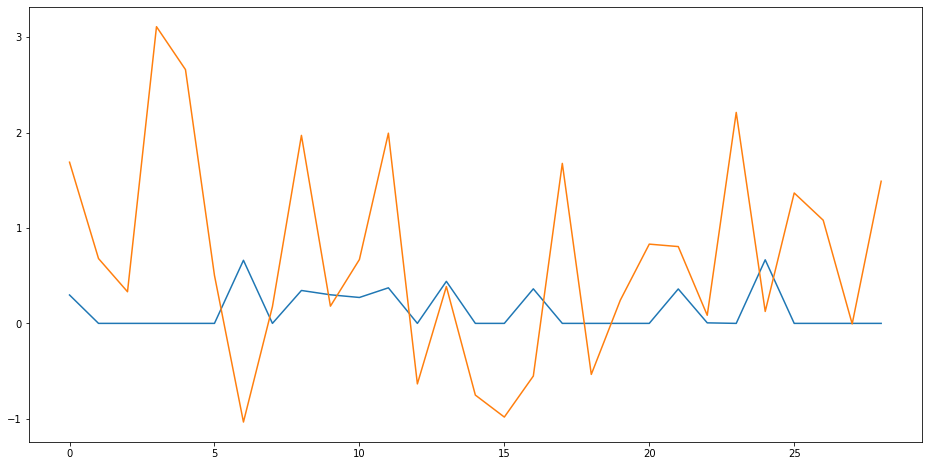

In [17]:
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(pred_train_op[0])        # Predicted Test Coefficient
ax.plot(alpha_k[0])              # Actual Test Coefficient

### Inverse Transform of Predicted Spatial Coefficients

In [18]:
pred_alpha_k = np.zeros([alpha_k.T.shape[0], len(latlon)])
#pred_alpha_k[:,0:len(known_latlon)] = pred_train_op.T
#pred_alpha_k[:,len(known_latlon):len(known_latlon)+len(unknown_latlon)] = pred_intr_op.T
pred_intr = coff_scaler.inverse_transform(pred_intr_op)    # Perform Inverse Tranform
pred_train = coff_scaler.inverse_transform(pred_train_op)    # Perform Inverse Tranform

### Compare and Plot Actual and Predicted Test Coefficients

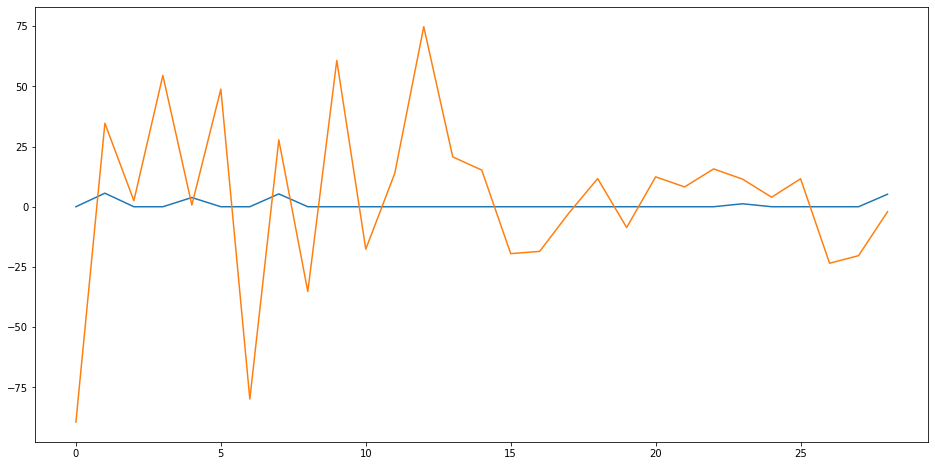

In [19]:
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(pred_train[28])
ax.plot(alpha_k_.T[28])

### Perform Coefficicent Interpolation

In [20]:
pred_intr_coeff = np.dot(pred_intr, pca.components_[:K_]) 

### Test Data Prediction - dot product of predicted spatial coefficients and orthogonal basis (PCA components)

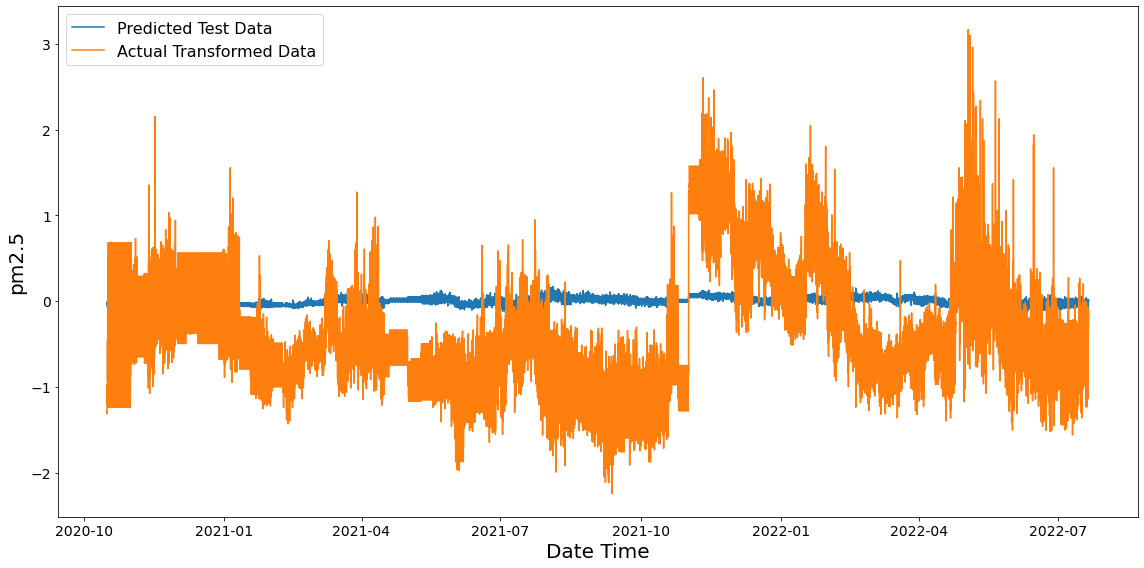

In [21]:
test_pred = np.dot(pred_train, pca.components_[:K_])    # Predicted Test Data (dot product of predicted spatial coefficients and orthogonal basis - PCA components)
#y_pred = np.dot(coff_scaler.inverse_transform(alpha_k), pca.components_[:K_])
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(DateTime[:-1], test_pred[28], label = 'Predicted Test Data')          # Plot Predicted Test Data
ax.plot(DateTime[:-1], y_ini_prediction[28], label = 'Actual Transformed Data')   # Actual Transformed Data
ax.set_ylabel('pm2.5',fontsize=20)
ax.set_xlabel('Date Time',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(loc='best', fontsize=16)
plt.tight_layout()
#plt.savefig('fig/ignnk_pm2p5.pdf')
plt.show()

### Transform Interpolated Data

In [22]:
Interpolated_Data = data_scaler.inverse_transform(pred_intr_coeff)

### Plot Transformed predicted Test data and True Data

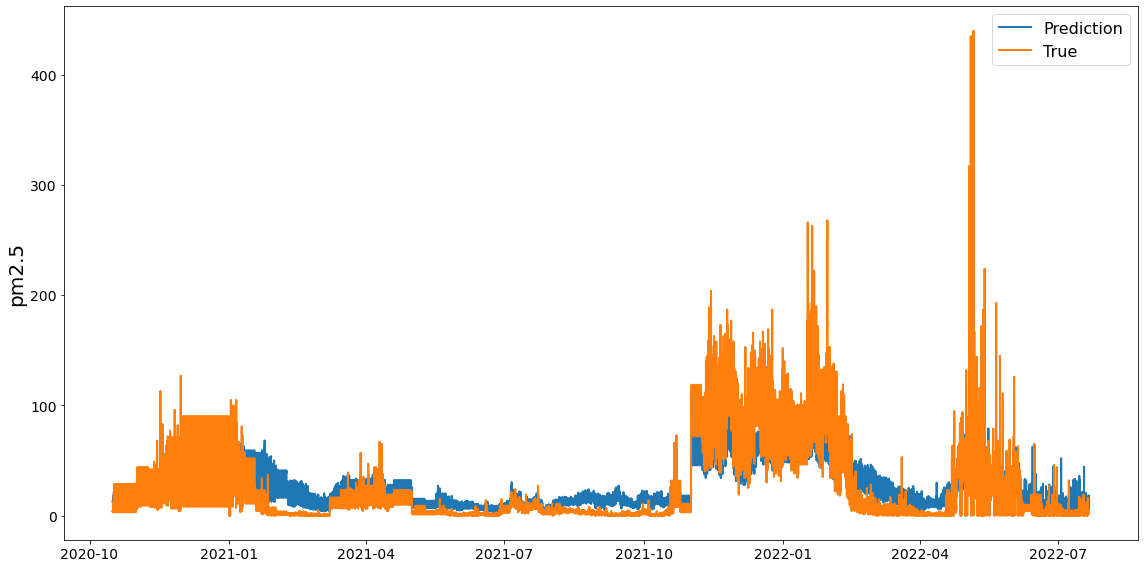

In [23]:
test_pred_trans = data_scaler.inverse_transform(test_pred)
y_pred_trans = data_scaler.inverse_transform(y_ini_prediction)
fig,ax = plt.subplots(figsize = (16,8))
ax.plot(DateTime[:-1], test_pred_trans[28], label = 'Prediction', linewidth = 2)
#ax.plot(y_ini_pred_trans[indices_test[0]])
ax.plot(DateTime[:-1], actual_data[28], label = 'True', linewidth = 2)
ax.set_ylabel('pm2.5',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#ax.set_xticks(range(0,1000,50))
#ax.set_xticklabels(['0:00\nMar 3rd','4:00','8:00','12:00','16:00','20:00','0:00\nMar 4th'])
ax.legend(loc='best', fontsize=16)
plt.tight_layout()
#plt.savefig('nature_pm2p5_kmin_Nadam_0p0001.pdf')
plt.show()

### Plotting Results

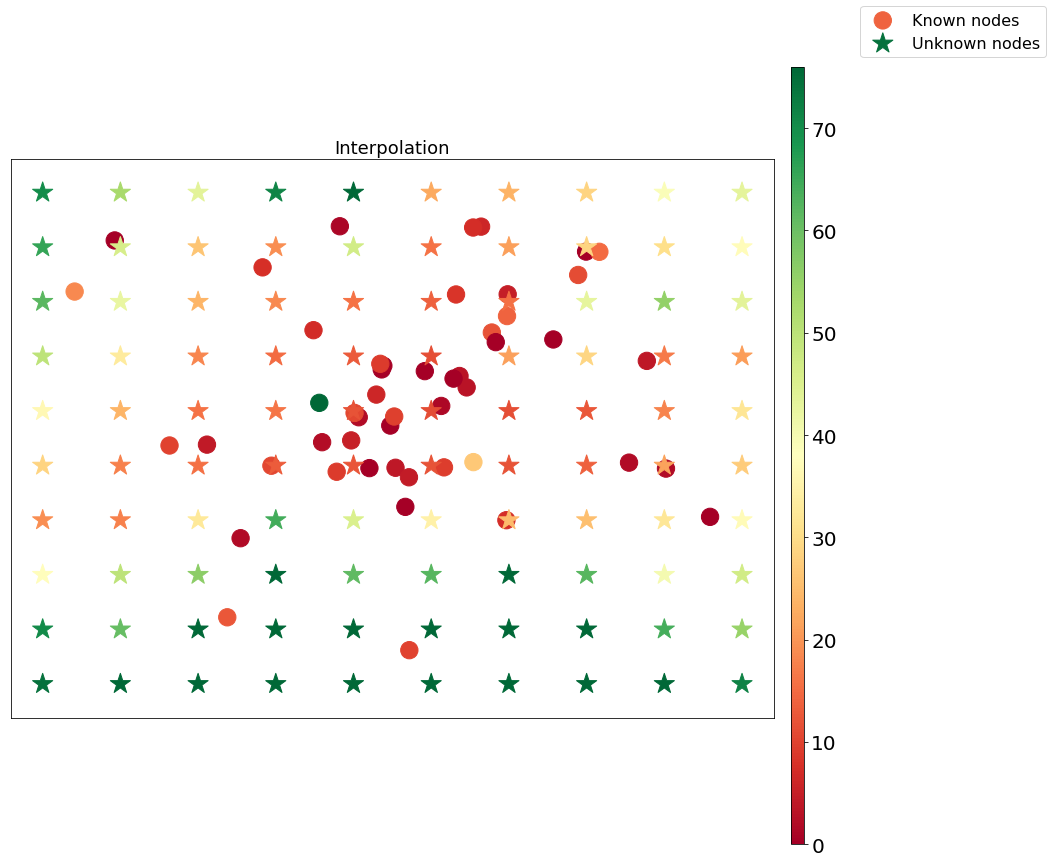

In [25]:
fig,ax = plt.subplots(figsize = (12,12))
lng_div = 0.01
lat_div = 0.01
map_pune.plot(ax = ax, color='black')
ax.set_xlim((np.min(latlon['longitude'])-lng_div,np.max(latlon['longitude'])+lng_div))
ax.set_ylim((np.min(latlon['latitude'])-lat_div,np.max(latlon['latitude'])+lat_div))
ax.set_xticks([])
ax.set_yticks([])
cax = ax.scatter(latlon['longitude'][0:50],latlon['latitude'][0:50],s=300,cmap=plt.cm.RdYlGn, c = time_series_data[:,-10],
        norm=mlt.colors.Normalize(vmin=time_series_data[:,-1].min(), vmax = time_series_data[:,-1].max()),alpha=1,label='Known nodes')
cax1 = ax.scatter(latlon['longitude'][50:],latlon['latitude'][50:],s=450,cmap=plt.cm.RdYlGn,c = Interpolated_Data[:,-10],
        norm=mlt.colors.Normalize(vmin=time_series_data[:,-1].min(), vmax = time_series_data[:,-1].max()),alpha=1,marker='*',label = 'Unknown nodes')
#ax.set_ylabel(ylbs[row],fontsize=20)
ax.set_title('Interpolation',fontsize = 18)

fig.tight_layout()
fig.subplots_adjust(right = 0.9,hspace=0,wspace =0,bottom=0,top=1)
l = 0.92
b = 0.03
w = 0.015
h = 0.9
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.figlegend(handles=(cax,cax1),labels=('Known nodes','Unknown nodes'),bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize = 16 )
#plt.savefig('fig/IGNNK_interpolation_pm2p5.pdf')
plt.show()